In [98]:
import numpy as np
import pandas as pd
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
import gzip
import scipy.sparse as sparse

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (7.2,4.45)
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['font.size'] = 22
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['lines.markersize'] = 13
plt.style.use('seaborn-white')

### Paths to HTMs

In [2]:
path_models_ctm = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/models_htm_ctm")
path_models_mallet = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/models_htm")
path_models = path_models_mallet

### Get root models

In [3]:
dfs = []
for entry in path_models.iterdir():
    # check if it is a root model
    if "root" in entry.as_posix():
        # Path to the root model
        path = entry
        
        # Thr and exp_tpc do not apply for the root model
        thr = -1
        exp_tpc = -1
        
        # Experiment iteration
        iter_ = int(entry.as_posix().split("model_")[1].split("_")[0])
        
        # Size of the topics
        alphas = np.load(path.joinpath('TMmodel/alphas.npy')).tolist()
        
        # Coherences (CV and NPMI)
        cohrs = np.load(path.joinpath('TMmodel/topic_coherence.npy')).tolist()
        if len(cohrs) > len(alphas):
            cohrs_cv = cohrs[0:len(alphas)]
            cohrs_npmi = cohrs[len(alphas):]
        elif len(cohrs) == len(alphas):
            cohrs_cv = cohrs
            cohrs_npmi = [0] * len(alphas)
        
        # Topics' entropies
        entropies = np.load(path.joinpath('TMmodel/topic_entropy.npy')).tolist()
        
        # Ids of the topics
        tpc_ids = np.arange(0,len(alphas),1)
        
        # Corpus size
        if path.joinpath('corpus.txt').is_file():
            corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
            size = len(corpus)
        elif path.joinpath('corpus.parquet').is_dir():
            dfc = pd.read_parquet(path.joinpath('corpus.parquet'))
            size = len(dfc)
            
        # Create dataframe for the root model
        root_tpc_df = pd.DataFrame(
            {'iter': [iter_] * len(alphas),
             'path': [path] * len(alphas),
             'cohrs_cv': cohrs_cv,
             'cohrs_npmi': cohrs_npmi,
             'entropies': entropies,
             'alphas': alphas,
             'tpc_ids': tpc_ids,
             'thr': [thr] * len(alphas),
             'exp_tpc': [exp_tpc] * len(alphas),
             'size': [size] * len(alphas),
             'tr_tpcs': [0] * len(alphas),
            })
        
        # Append to the list of dataframes to concatenate them
        dfs.append(root_tpc_df)
df = pd.concat(dfs)
df = df.sort_values(by=['iter'])
df

iter                                               path  cohrs_cv  \
4      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.704397   
0      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.663815   
1      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.627862   
2      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.608068   
3      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.811461   
..   ...                                                ...       ...   
5      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.600878   
6      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.671080   
7      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.715144   
9      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.722527   
8      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.680224   

    cohrs_npmi  entropies    alphas  tpc_ids  thr  exp_tpc   size  tr_tpcs  
4     0.108367   0.750662  0.105999        4   -1       -1  61117        0  
0     0.089120   0.708070  0.136753        0   -1       -1  61117        0  
1     0.069443   0.738289  0.134788        1   -1       -1  61117        0  
2     0.061690   0.740324  0.127286        2   -1       -1  61117        0  
3     0.126923   0.728410  0.110195        3   -1       -1  61117        0  
..         ...        ...       ...      ...  ...      ...    ...      ...  
5     0.083477   0.761156  0.089879        5   -1       -1  61117        0  
6     0.106745   0.738318  0.086353        6   -1       -1  61117        0  
7     0.117901   0.733219  0.083156        7   -1       -1  61117        0  
9     0.130449   0.726316  0.049645        9   -1       -1  61117        0  
8     0.108474   0.733714  0.078149        8   -1       -1  61117        0  

[100 rows x 11 columns]

In [4]:
if df.iloc[0].path.joinpath('corpus.txt').is_file():
    corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                df.iloc[0].path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
    root_size = len(corpus)
elif df.iloc[0].path.joinpath('corpus.parquet').is_dir():
    dfc = pd.read_parquet(df.iloc[0].path.joinpath('corpus.parquet'))
    root_size = len(dfc)
root_size

61117

### Get submodels

In [5]:
# Iter over each root model (according to its corresponding iteration, iter)
concats = [df]
not_finished = []
for el in df.iter.unique():
    path_root = df[df.iter == el].iloc[0].path
    for entry in path_root.iterdir():
        if entry.joinpath('TMmodel/topic_coherence.npy').is_file():
        
            if "ws" in entry.as_posix():
                thr = 0
                size = 0
            else:
                thr = float(entry.as_posix().split("thr_")[1].split("_")[0])
                
                if entry.joinpath('corpus.txt').is_file():
                    corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                                entry.joinpath('corpus.txt'), encoding="utf-8").readlines()]
                    size = len(corpus)
                elif entry.joinpath('corpus.parquet').is_dir():
                    dfc = pd.read_parquet(entry.joinpath('corpus.parquet'))
                    size = len(dfc)
                size = size * 100 / root_size

            # get topic from which the submodel is generated
            exp_tpc = int(entry.as_posix().split("from_topic_")[1].split("_")[0])
            
            
            # Size of the topics
            alphas = np.load(entry.joinpath('TMmodel/alphas.npy')).tolist()
        
            # Alphas submodel is the mean of the cohr of its topics
            alpha = np.mean(alphas)
            
            # Coherences (CV and NPMI)
            cohrs = np.load(entry.joinpath('TMmodel/topic_coherence.npy')).tolist()
            if len(cohrs) > len(alphas):
                cohrs_cv = cohrs[0:len(alphas)]
                cohrs_npmi = cohrs[len(alphas):]
            elif len(cohrs) == len(alphas):
                cohrs_cv = cohrs
                cohrs_npmi = [0] * len(alphas)
            
            # cohr submodel is the mean of the cohr of its topics
            cohr_cv = np.mean(cohrs_cv)
            cohr_npmi = np.mean(cohrs_npmi)
            
            # Topics' entropies
            entropy = np.mean(np.load(entry.joinpath('TMmodel/topic_entropy.npy')).tolist())
            
            tr_tpcs = int(entry.as_posix().split("train_with_")[1].split("_")[0])
            
            # add entry of submodel to dataframe
            root_tpc_df = pd.DataFrame(
            {'iter': [el],
             'path': [entry],
             'cohrs_cv': [cohr_cv],
             'cohrs_npmi': [cohr_npmi],
             'entropies': [entropy],
             'alphas': [alpha],
             'tpc_ids': [exp_tpc],
             'thr': [thr],
             'exp_tpc': [exp_tpc],
             'size': [size],
             'tr_tpcs': [tr_tpcs]
            })
            concats.append(root_tpc_df)
        else:
            not_finished.append(entry)
df = pd.concat(concats)

### Generate graphs for root models

In [6]:
df_root = df[df.thr==-1]
df_root

iter                                               path  cohrs_cv  \
4      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.704397   
0      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.663815   
1      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.627862   
2      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.608068   
3      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.811461   
..   ...                                                ...       ...   
5      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.600878   
6      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.671080   
7      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.715144   
9      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.722527   
8      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.680224   

    cohrs_npmi  entropies    alphas  tpc_ids  thr  exp_tpc     size  tr_tpcs  
4     0.108367   0.750662  0.105999        4 -1.0       -1  61117.0        0  
0     0.089120   0.708070  0.136753        0 -1.0       -1  61117.0        0  
1     0.069443   0.738289  0.134788        1 -1.0       -1  61117.0        0  
2     0.061690   0.740324  0.127286        2 -1.0       -1  61117.0        0  
3     0.126923   0.728410  0.110195        3 -1.0       -1  61117.0        0  
..         ...        ...       ...      ...  ...      ...      ...      ...  
5     0.083477   0.761156  0.089879        5 -1.0       -1  61117.0        0  
6     0.106745   0.738318  0.086353        6 -1.0       -1  61117.0        0  
7     0.117901   0.733219  0.083156        7 -1.0       -1  61117.0        0  
9     0.130449   0.726316  0.049645        9 -1.0       -1  61117.0        0  
8     0.108474   0.733714  0.078149        8 -1.0       -1  61117.0        0  

[100 rows x 11 columns]

In [7]:
df1 = df_root.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'alphas']].mean()
df1 = df1.rename(columns={'cohrs_cv': 'cohrs_cv_mean',
                          'cohrs_npmi': 'cohrs_npmi_mean',
                          'entropies': 'entropies_mean',
                          'alphas': 'alphas_mean',
                         })

df2 = df_root.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies']].var()
df2 = df2.rename(columns={'cohrs_cv': 'cohrs_cv_var',
                          'cohrs_npmi': 'cohrs_npmi_var',
                          'entropies': 'entropies_var',
                         })

df_root_plot = pd.concat([df1, df2], axis=1, join='inner')

df_root_plot['tpc_ids'] = np.arange(0,len(df_root_plot),1)
df_root_plot

cohrs_cv_mean  cohrs_npmi_mean  entropies_mean  alphas_mean  \
tpc_ids                                                                
0             0.675498         0.091840        0.710538     0.138250   
1             0.620522         0.071549        0.737389     0.130660   
2             0.658178         0.079111        0.737644     0.124784   
3             0.744955         0.113162        0.735883     0.108842   
4             0.663421         0.094525        0.752984     0.100592   
5             0.633516         0.091543        0.749839     0.090083   
6             0.690709         0.113256        0.738069     0.085961   
7             0.717010         0.118815        0.736542     0.082737   
8             0.681460         0.101983        0.731108     0.075626   
9             0.713244         0.124360        0.725394     0.062463   

         cohrs_cv_var  cohrs_npmi_var  entropies_var  tpc_ids  
tpc_ids                                                        
0            0.002493        0.000137       0.000156        0  
1            0.000519        0.000032       0.000005        1  
2            0.007068        0.000781       0.000009        2  
3            0.006374        0.000298       0.000403        3  
4            0.002132        0.000204       0.000079        4  
5            0.008543        0.001237       0.000173        5  
6            0.003512        0.000352       0.000004        6  
7            0.001678        0.000253       0.000042        7  
8            0.001783        0.000240       0.000072        8  
9            0.001330        0.000254       0.000091        9

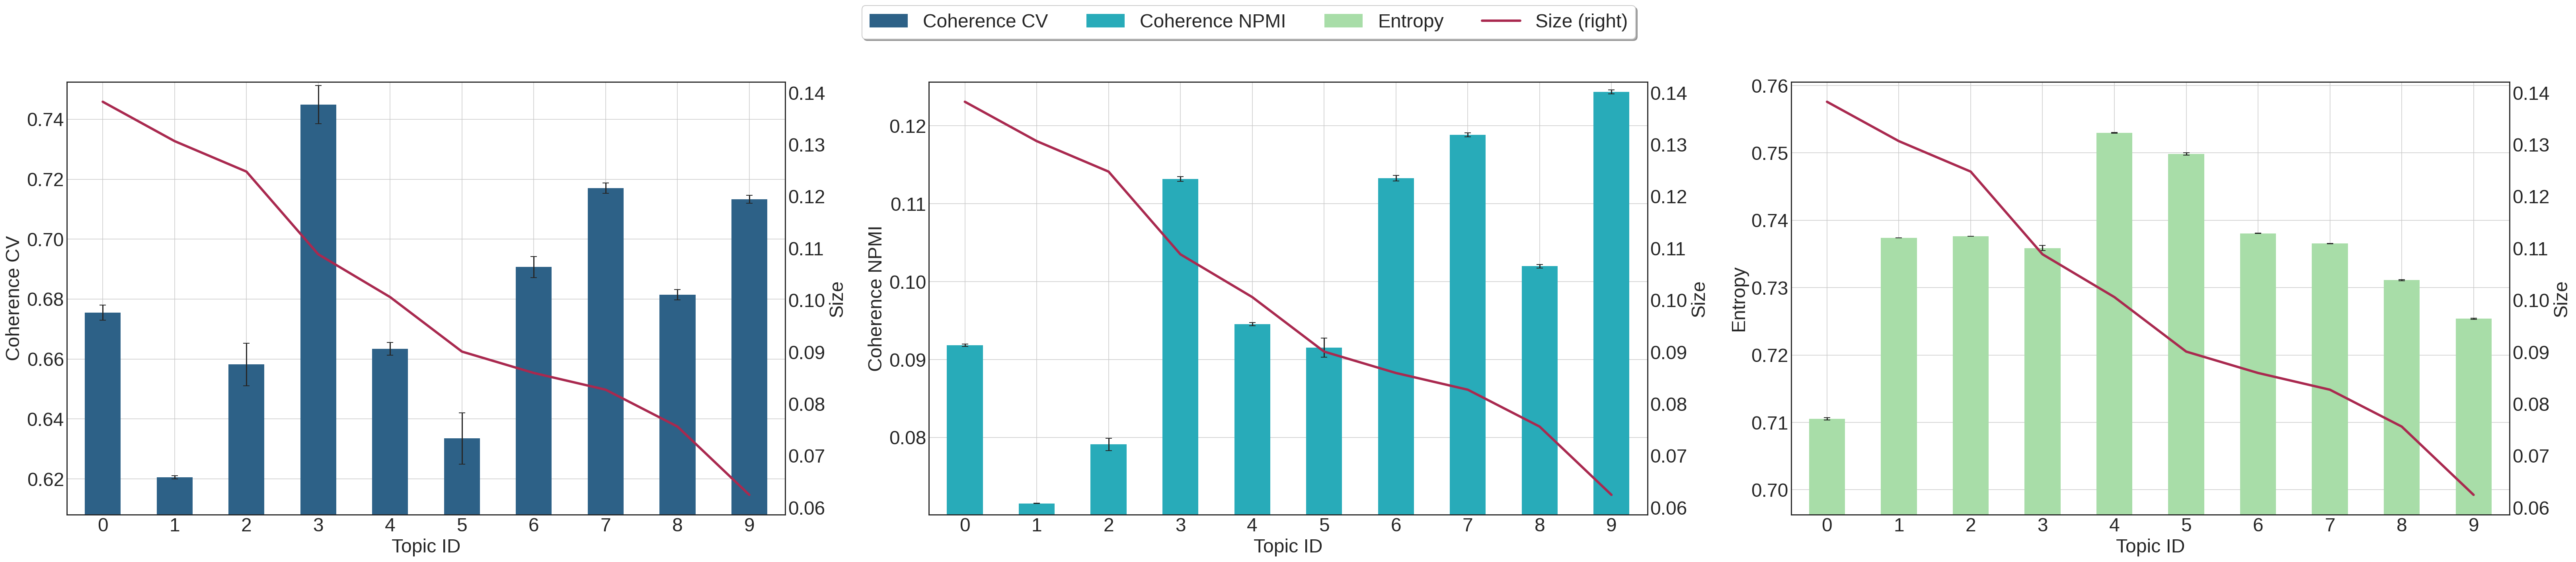

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (55, 10))
y_repr = ['cohrs_cv', 'cohrs_npmi', 'entropies']
y_labels = ['Coherence CV', 'Coherence NPMI', 'Entropy']
colors = ["#2D6187", "#28ABB9", "#A8DDA8"]

labels_all = []
handles_all = []
for yrepr, ylabel, color, ax in zip(y_repr, y_labels, colors, axs.flat):
    
    df_root_plot.plot.bar(
        ax=ax,
        y=yrepr + "_mean",
        yerr = yrepr + "_var",
        label=ylabel, use_index=True, stacked=True,
        color = color,
        capsize=4)
    ax2 = df_root_plot.plot(
            ax=ax, 
            y='alphas_mean', kind = 'line', linewidth=3, label='Size', color="#A9294F", use_index=True, secondary_y=True)

    ax.grid()
    ax.set_xlabel('Topic ID')
    ax.set_ylabel(ylabel)
    ax.set_ylim([df_root_plot[yrepr + "_mean"].values.min()*0.98, df_root_plot[yrepr + "_mean"].values.max()*1.01])
    ax2.set_ylabel('Size')
    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    labels_all += labels
    handles_all += handles

handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.03),
           frameon=True, shadow=True)

### Get graphs for HTM-WS submodels

In [9]:
df_ws = df[df.thr==0]

concat = []
for el in df_ws.tr_tpcs.unique():
    
    df1 = df_ws[df_ws.tr_tpcs==el].groupby('exp_tpc')[['cohrs_cv', 'cohrs_npmi', 'entropies']].mean()
    df1 = df1.rename(columns={'cohrs_cv': 'cohrs_cv_mean' + "_" + str(el),
                              'cohrs_npmi': 'cohrs_npmi_mean' + "_" + str(el),
                              'entropies': 'entropies_mean' + "_" + str(el)
                             })
    concat.append(df1)

    df2 = df_ws[df_ws.tr_tpcs==el].groupby('exp_tpc')[['cohrs_cv', 'cohrs_npmi', 'entropies']].var()
    df2 = df2.rename(columns={'cohrs_cv': 'cohrs_cv_var' + "_" + str(el),
                              'cohrs_npmi': 'cohrs_npmi_var' + "_" + str(el),
                              'entropies': 'entropies_var' + "_" + str(el)
                             })
    concat.append(df2)

df_ws_plot = pd.concat(concat, axis=1, join='inner').reset_index()

df_ws_plot

exp_tpc  cohrs_cv_mean_10  cohrs_npmi_mean_10  entropies_mean_10  \
0        0          0.723935            0.075797           0.719303   
1        1          0.706008            0.066301           0.720779   
2        2          0.712731            0.063880           0.722536   
3        3          0.719355            0.068777           0.724376   
4        4          0.715670            0.070332           0.711470   
5        5          0.734915            0.076610           0.723049   
6        6          0.706837            0.063023           0.717112   
7        7          0.704468            0.065974           0.714029   
8        8          0.692267            0.057802           0.715474   
9        9          0.699556            0.062801           0.714845   

   cohrs_cv_var_10  cohrs_npmi_var_10  entropies_var_10  cohrs_cv_mean_6  \
0         0.002728           0.000413          0.000234         0.717883   
1         0.000994           0.000148          0.000140         0.704892   
2         0.001207           0.000494          0.000116         0.706126   
3         0.000888           0.000047          0.000254         0.723812   
4         0.001454           0.000220          0.000055         0.704866   
5         0.001469           0.000328          0.000243         0.725418   
6         0.001266           0.000351          0.000192         0.712050   
7         0.000320           0.000051          0.000129         0.697011   
8         0.002122           0.000478          0.000068         0.692877   
9         0.000880           0.000155          0.000165         0.698357   

   cohrs_npmi_mean_6  entropies_mean_6  cohrs_cv_var_6  cohrs_npmi_var_6  \
0           0.069911          0.718593        0.001550          0.000172   
1           0.063457          0.720316        0.001231          0.000234   
2           0.061770          0.722768        0.001613          0.000365   
3           0.068749          0.723870        0.000885          0.000137   
4           0.065553          0.711746        0.001823          0.000436   
5           0.072095          0.722649        0.001353          0.000233   
6           0.065553          0.716276        0.001792          0.000343   
7           0.060581          0.714668        0.001227          0.000180   
8           0.058643          0.715639        0.001191          0.000213   
9           0.062067          0.714615        0.000736          0.000134   

   entropies_var_6  cohrs_cv_mean_8  cohrs_npmi_mean_8  entropies_mean_8  \
0         0.000210         0.717549           0.069544          0.719234   
1         0.000154         0.698743           0.062168          0.719562   
2         0.000125         0.713480           0.065810          0.722240   
3         0.000293         0.721172           0.066877          0.724637   
4         0.000062         0.702053           0.065677          0.713414   
5         0.000246         0.724094           0.068603          0.720911   
6         0.000187         0.719334           0.069099          0.716205   
7         0.000105         0.695819           0.061951          0.714640   
8         0.000070         0.680021           0.053770          0.715546   
9         0.000130         0.701172           0.063481          0.715283   

   cohrs_cv_var_8  cohrs_npmi_var_8  entropies_var_8  
0        0.001165          0.000114         0.000222  
1        0.001314          0.000178         0.000137  
2        0.001304          0.000190         0.000140  
3        0.000837          0.000085         0.000304  
4        0.002296          0.000571         0.000053  
5        0.001865          0.000466         0.000232  
6        0.001389          0.000346         0.000170  
7        0.000991          0.000147         0.000104  
8        0.001637          0.000336         0.000065  
9        0.000922          0.000086         0.000114

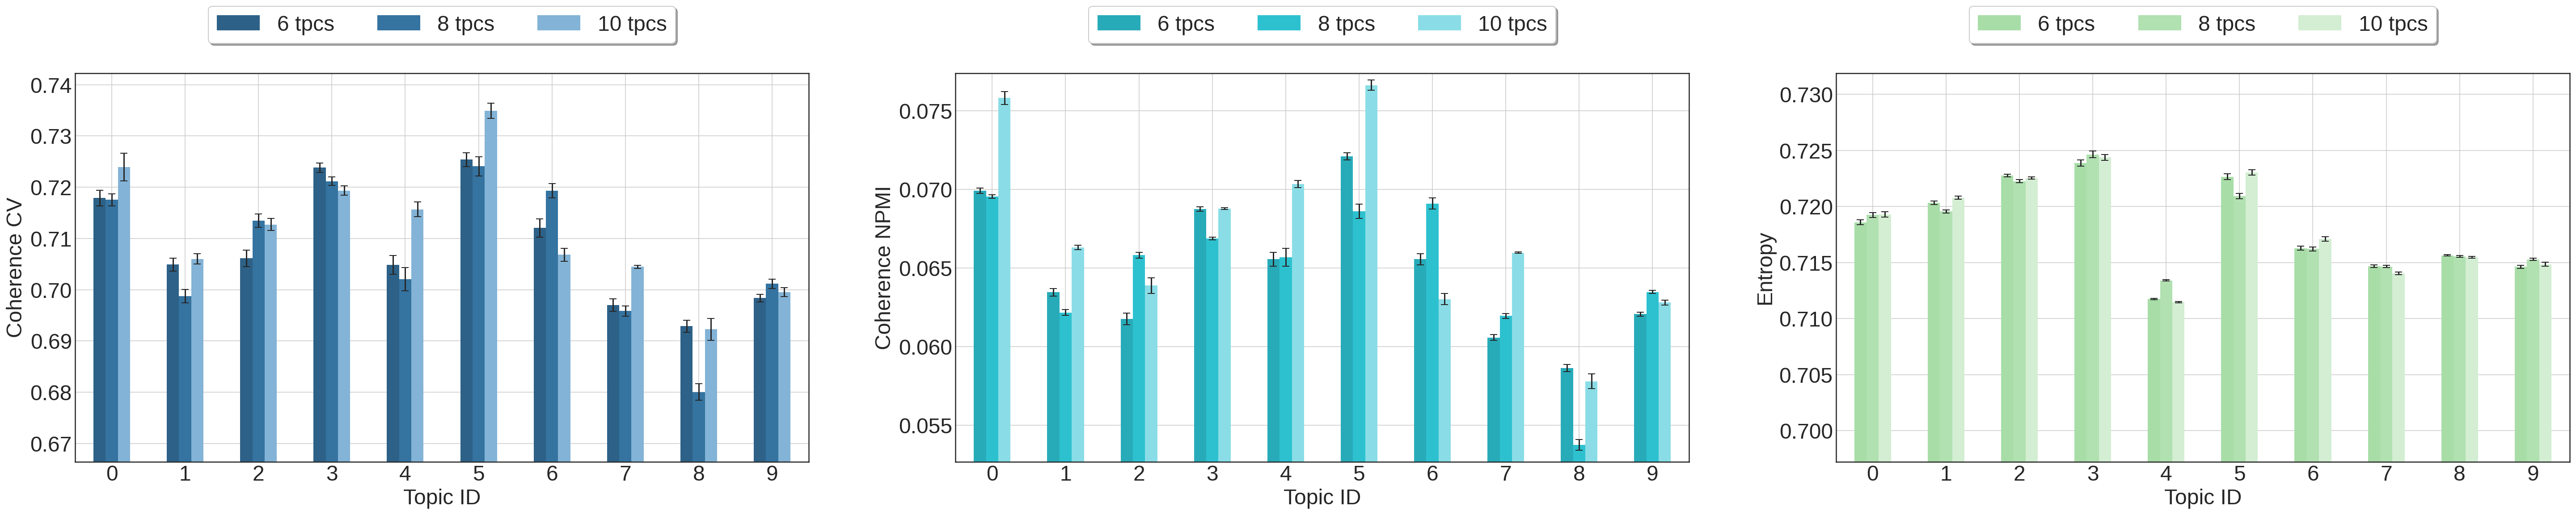

In [110]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (50, 8))
y_repr = ['cohrs_cv', 'cohrs_npmi', 'entropies']
y_labels = ['Coherence CV', 'Coherence NPMI', 'Entropy']
colors = [['#2D6187','#3573A0','#83B3D6'],
          ['#28ABB9','#2dc1d0','#8adde6'],
          ['#A8DDA8','#b1e0b1','#d3eed3']]

for yrepr, ylabel, color, ax in zip(y_repr, y_labels, colors, axs.flat):
    aux = [df_ws_plot[yrepr + "_var_6"].values,
           df_ws_plot[yrepr + "_var_8"].values, 
           df_ws_plot[yrepr + "_var_10"].values]
    y_aux = [yrepr + "_mean_6", yrepr + "_mean_8", yrepr + "_mean_10"]
    df_ws_plot.plot.bar(
        x='exp_tpc',
        ax=ax,
        y= y_aux,
        yerr = aux,
        label=['6 tpcs', '8 tpcs', '10 tpcs'],
        color=color,
        capsize=4)
    
    ax.grid()
    ax.set_xlabel('Topic ID')
    ax.set_ylabel(ylabel)
    ax.set_ylim([df_ws_plot[y_aux].values.min()*0.98, df_ws_plot[y_aux].values.max()*1.01])
    ax.set_xticklabels(ax.get_xticks(), rotation = 0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          frameon=True, shadow=True, ncol=3)
    
plt.show()

In [11]:
prop_min = (600*100)/root_size
prop_max = 30

### Get graphs for HTM-DS submodels

In [12]:
df_ds = df[df.thr>0]
df_ds

iter                                               path  cohrs_cv  \
0      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.625394   
0      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.590477   
0      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.409839   
0      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.605259   
0      0  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.615552   
..   ...                                                ...       ...   
0      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.512681   
0      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.651995   
0      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.544977   
0      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.619545   
0      9  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.534866   

    cohrs_npmi  entropies  alphas  tpc_ids  thr  exp_tpc       size  tr_tpcs  
0     0.077096   0.712614     0.1        8  0.1        8  16.155898       10  
0     0.059585   0.701818     0.1        1  0.8        1   5.299671       10  
0    -0.064525   0.699101     0.1        7  0.9        7   0.787015        6  
0     0.080402   0.705071     0.1        3  0.1        3  19.269598       10  
0     0.076803   0.725744     0.1        5  0.2        5  12.860579        8  
..         ...        ...     ...      ...  ...      ...        ...      ...  
0     0.027882   0.702168     0.1        7  0.6        7   4.923344        6  
0     0.091590   0.716822     0.1        6  0.1        6  16.789109        8  
0     0.043294   0.706989     0.1        7  0.4        7   9.107122       10  
0     0.083033   0.692324     0.1        0  0.3        0  17.242338       10  
0     0.041566   0.703005     0.1        7  0.5        7   6.868793        8  

[2700 rows x 11 columns]

In [138]:
metrics_display = ['cohrs_cv', 'cohrs_npmi', 'entropies']
y_labels = ['Coherence CV', 'Coherence NPMI', 'Entropy']
colors = [['#2D6187','#3573A0','#83B3D6'],
          ['#28ABB9','#2dc1d0','#8adde6'],
          ['#A8DDA8','#b1e0b1','#d3eed3']]
maxs_mins = [(0.98,1.05),(-0.98,1.2),(0.98,1.02)]

for metric,label,color,max_min in zip(metrics_display,y_labels,colors,maxs_mins):
    
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize = (50, 50), sharex=True, sharey=True)

    for tpc, ax in zip(sorted(df_ds.exp_tpc.unique()), axs.flat):
        aux_df_ds = df_ds[df_ds.exp_tpc==tpc]
        concat = []
        for el in aux_df_ds.tr_tpcs.unique():

            df1 = aux_df_ds[aux_df_ds.tr_tpcs==el].groupby('thr')[[metric,'size']].mean()
            df1 = df1.rename(columns={metric: metric + '_mean_' + str(el),
                                      'size':  'size_mean' + "_" + str(el)})
            concat.append(df1)

            df2 = aux_df_ds[aux_df_ds.tr_tpcs==el].groupby('thr')[[metric,'size']].var()
            df2 = df2.rename(columns={metric: metric + '_var_' + str(el),
                                      'size':  'size_var' + "_" + str(el)})
            concat.append(df2)

        aux_df_ds_plot = pd.concat(concat, axis=1, join='inner').reset_index()
                
        aux = [aux_df_ds_plot[metric + "_var_6"].values,
               aux_df_ds_plot[metric + "_var_8"].values, 
               aux_df_ds_plot[metric + "_var_10"].values]
            
        y_aux = [metric + "_mean_6", metric + "_mean_8", metric + "_mean_10"]

        aux_df_ds_plot.plot.bar(
                ax=ax,
                x='thr',
                y=y_aux,#['cohrs_mean_6','cohrs_mean_8','cohrs_mean_10'],
                yerr = aux,
                label=['6 tpcs', '8 tpcs', '10 tpcs'], use_index=True,
                color=color,
                capsize=4, rot=0)

        ax2 = aux_df_ds_plot.plot(
                ax=ax, 
                y='size_mean_6', 
                kind = 'line',
                color='#A9294F',
                label='Nr docs', 
                secondary_y=True,
                linewidth=3)

        ax2.hlines(y=[prop_max,prop_min], xmin=-1, xmax=len(aux_df_ds_plot.thr.unique()),
                   colors='purple', linestyles='--', lw=3,
                   label='Nr docs max / Nr docs min')
        ax2.set_ylim([0, 32])
        ax.set_ylim([aux_df_ds_plot[y_aux].values.min()*(max_min[0]), aux_df_ds_plot[y_aux].values.max()*max_min[1]])
        ax.set_xlabel('Threshold')
        ax.set_title(f'Submodels generated from topic {tpc}')
        ax.get_legend().remove()
        ax.grid()

    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles+handles2, labels+labels2, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.02),
              frameon=True, shadow=True)
    
    
    fig.text(-0.01, 0.5, label, va='center', rotation='vertical')
    fig.text(1.01, 0.5,'% of docs in the original corpus', va='center', rotation='vertical')
    fig.tight_layout()